# Mie散乱の理論を実装する

In [1]:
#import scipy
import numpy as np
import sympy as sym
from scipy.special import legendre,jv,hankel2
from scipy.misc import derivative
import matplotlib.pyplot as plt

In [2]:
# scipyのintegrateをインポート
from scipy import integrate

# 積分する関数の定義(今回はx^2)
def f(x):
  return x**2

# 上限値と下限値の入力
a = int(input("下限"))
b = int(input("上限"))
ans,err = integrate.quad(f,a,b)

ValueError: invalid literal for int() with base 10: ''

### π_n(cosθ)

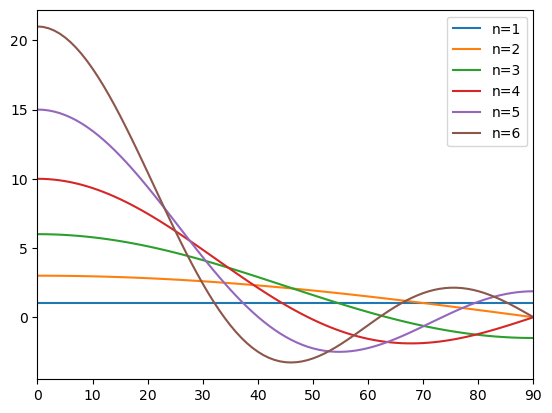

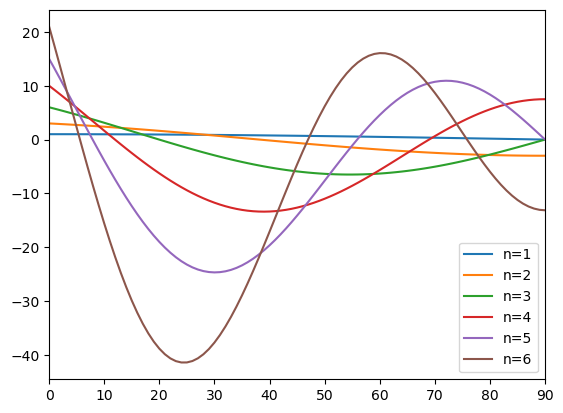

In [2]:
def pi_n(n,theta):
    """
    thetaは度数で与えること
    p124中頃の式だとsinθで割っているが、
    これはルジャンドル多項式の変数がcosのときに微分することでsinの項が出てくるため。（おそらく-を忘れている誤植。）
    """
    cos = np.cos(np.radians(theta))
    sin = np.sin(np.radians(theta))
    legendre_func = legendre(n)
    legendre_func_derivative = legendre_func.deriv()
    return legendre_func_derivative(cos)#/sin

#test
pi_n(3,30)
fig,ax = plt.subplots()
radians = [i for i in range(0,91)]
#radians = [30,60,90]
for i in range(1,7):
    pi = [pi_n(i,radian) for radian in radians]
    ax.plot(radians,pi,label=f"n={i}")
ax.legend()
ax.set_xlim(0,90)
fig.savefig("../png/pi_n_v2.png")
### τ_n(cosθ)

def tau_n(n,theta):
    cos = np.cos(np.radians(theta))
    sin = np.sin(np.radians(theta))
    legendre_func = legendre(n)
    legendre_func_derivative = legendre_func.deriv()
    legendre_func_derivative_2 = legendre_func_derivative.deriv()
    
    return cos * pi_n(n,theta)- sin * legendre_func_derivative_2(cos)# - (cos * legendre_func_derivative(cos) /(sin **2)) - legendre_func_derivative_2(cos)
    #return - sin * legendre_func_derivative_2(cos)
tau_n(6,30)

fig,ax = plt.subplots()
radians = [i for i in range(0,91)]
for i in range(1,7):
    tau = [tau_n(i,radian) for radian in radians]
    ax.plot(radians,tau,label=f"n={i}")
ax.legend();ax.set_xlim(0,90)
fig.savefig("../png/tau_n.png")

In [2]:
def pi_n_tau_n(n,theta):
    pi_nSeries = np.zeros(n+1)
    x = np.cos(np.radians(theta))
    def Pi_n(n,x):
        if n >=2 :
            pi_nSeries[n] = (2*n-1)*x*Pi_n(n-1,x)/(n-1) - n*Pi_n(n-2,x)/(n-1)
            return (2*n-1)*x*Pi_n(n-1,x)/(n-1) - n*Pi_n(n-2,x)/(n-1)
        
        elif n == 1:
            pi_nSeries[n] = 1
            return 1
        else:
            pi_nSeries[n] = 0
            return 0
    pi_n = Pi_n(n,x)
    tau_n = n*x*pi_nSeries[n] - (n+1) * pi_nSeries[n-1]
    return pi_n,tau_n

In [3]:
def pi_n_tau_n(theta,iter=30):
    pi_n = np.zeros(iter)
    tau_n = np.zeros(iter)
    x = np.cos(np.radians(theta))
    pi_n[0] = 0
    pi_n[1] = 1
    tau_n[1] = x

    for i in range(2,iter):
        pi_n[i] = (2*i-1)*x*pi_n[i-1]/(i-1) - i*pi_n[i-2]/(i-1)
    for i in range(1,iter):
        tau_n[i] = i*x*pi_n[i] - (i+1) * pi_n[i-1]
    return pi_n,tau_n

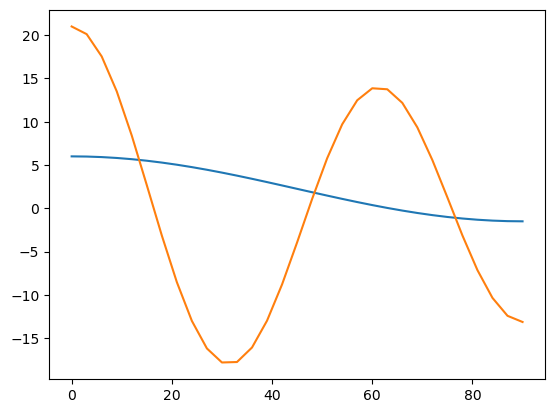

In [48]:
pi = [pi_n_tau_n(i,iter=8)[0][3] for i in np.arange(0,93,3)]
tau = [pi_n_tau_n(i,iter=8)[1][6] for i in np.arange(0,93,3)]
fig,ax = plt.subplots()
ax.plot(np.arange(0,93,3),pi)
ax.plot(np.arange(0,93,3),tau)
plt.show()

### psi_n

In [4]:
def psi_n(n,x):
    """
    psi_n is a key function of an and bn
    n(int): the order of the bessel function
    x(float): x= 2pi・a/λ
    a(float):The diameter of a single particle 
    """
    bessel = jv(n+1/2, x)
    return np.sqrt(np.pi*x/2)*bessel

def xi_n(n,x):
    """
    xi_n is a key function of an and bn
    n(int): the order of the bessel function
    x(float): x= 2pi・a/λ
    a(float):The diameter of a single particle 
    """
    bessel = hankel2(n+1/2, x)
    return np.sqrt(np.pi*x/2)*bessel

In [8]:
def diff_f(f,n,x, h):
    """
    psi_n,xi_nの数値微分用の関数。hを決めると微分係数の近似値が出る。
    bessel関数なので数値微分するしかない
    f(func): function you want to deriverate
    n(int): the order of the bessel function
    x(float): x= 2pi・a/λ
    h(float): h for limit h→0 (h should be near 0)
    """
    return (f(n,x+h)-f(n,x-h))/(2.0*h)

In [5]:
#from scipy.misc import derivative
# scipy.misc.derivative(func, x0, dx=1.0, n=1, args=(), order=3)

#ans = scipy.misc.derivative(f, 3, 1.0E-6)
def a_n_b_n(n,x,y,m,dx=1e-6):
    """
    S1(θ),S2(θ)を求めるための関数。
    return(tuple) : an,bn
    n(int): the order of the bessel function
    x(float): x= 2pi・a/λ
    y(float):y = mka = mx
    m(complex):refractive index complex
    """

    def psi_n(x):
        """
        psi_n is a key function of an and bn
        n(int): the order of the bessel function
        x(float): x= 2pi・a/λ
        a(float):The diameter of a single particle 
        """
        bessel = jv(n+1/2, x)
        return np.sqrt(np.pi*x/2)*bessel

    def xi_n(x):
        """
        xi_n is a key function of an and bn
        n(int): the order of the bessel function
        x(float): x= 2pi・a/λ
        a(float):The diameter of a single particle 
        """
        bessel = hankel2(n+1/2, x)
        return np.sqrt(np.pi*x/2)*bessel
    
    psi_derivative_x = derivative(psi_n,x,dx=dx)    ##psiのx=xでの微分係数
    xi_derivative_x = derivative(xi_n,x,dx=dx)  ##xiのx=xでの微分係数
    psi_derivative_y = derivative(psi_n,y,dx=dx)    ##psiのy=yでの微分係数
    #xi_derivative_y = derivative(xi_n,y,dx=dx) #

    numerator_an = psi_derivative_y * psi_n(x) - m * psi_n(y) *psi_derivative_x # anの分子
    denominator_an = psi_derivative_y * xi_n(x) - m * psi_n(y) *xi_derivative_x # anの分母
    an = numerator_an/denominator_an

    numerator_bn = m * psi_derivative_y * psi_n(x) -  psi_n(y) *psi_derivative_x # bnの分子
    denominator_bn = m * psi_derivative_y * xi_n(x) -  psi_n(y) *xi_derivative_x # bnの分母
    bn = numerator_bn/denominator_bn
    return an,bn

#def b_n(n,x,y,m,h=1e-6):
#    """
#    S1(θ),S2(θ)を求めるための関数。
#    n(int): the order of the bessel function
#    x(float): x= 2pi・a/λ
#    y(float):y = mka
#    m(float or complex?):refractive index (complex?) or real part?   
#    """
#    psi_derivative_x = diff_f(psi_n,n,x,h)
#    xi_derivative_x = diff_f(xi_n,n,x,h)
#    psi_derivative_y = diff_f(psi_n,n,y,h)
#    #xi_derivative_y = diff_f(xi_n,n,y,h)
#
#
#    
#    return numerator/denominator

In [ ]:
x = 2*np.pi*1e-6/(440*1e-9)
m = 1.023
a_n(3,x,m*x,m)

(0.10455757282611454+0.30598249423231233j)

### S_1(θ), S_2(θ)

In [6]:
def S_1_S_2(theta,x,y,m,iter=30):
    """
    S1(θ)を求めるための関数。
    theta(int): 散乱角。入射角の方向が0度である。
    x(float): x= 2pi・a/λ
    y(float):y = mka
    m(float or complex?): refractive index (complex?) or real part?  
    iter(int,optional): since this function is infinite series, the upper limit for iteration should be determined.
    """
    sum_s1 = 0;sum_s2 = 0
    pi_n,tau_n = pi_n_tau_n(theta,iter=iter+1)
    for n in range(1,iter):
        an,bn = a_n_b_n(n,x,y,m,dx=1e-6)
        
        numerator_1 = 2*n+1
        numerator_2_s1 = an * pi_n[n] + bn * tau_n[n]
        numerator_2_s2 = bn * pi_n[n] + an * tau_n[n]
        denominator = n * (n+1)
        #print( numerator_1,numerator_2,denominator)
        sum_s1 += (numerator_1*numerator_2_s1)/denominator
        sum_s2 += (numerator_1*numerator_2_s2)/denominator
    return sum_s1,sum_s2

In [ ]:
#def S_2(theta,x,y,m,iter=30):
#    """
#    S2(θ)を求めるための関数。
#    theta(int): 散乱角。入射角の方向が0度である。
#    x(float): x= 2pi・a/λ
#    y(float):y = mka
#    m(float or complex?): refractive index (complex?) or real part?  
#    iter(int,optional): since this function is infinite series, the upper limit for iteration should be determined.
#    """
#    sum = 0
#    for n in range(1,iter):
#        numerator_1 = 2*n+1
#        numerator_2 = b_n(n,x,y,m) * pi_n(n,theta) + a_n(n,x,y,m) * tau_n(n,theta)
#        denominator = n * (n+1)
#        sum += (numerator_1*numerator_2)/denominator
#    return sum    

In [7]:
def cal_abs(theta,x,y,m,iter=30):
    """
    i_1,i_2を求める。S1,S2は虚数なので絶対値の二乗を求める。これにより実数となる。
    theta(int): 散乱角。入射角の方向が0度である。
    x(float): x= 2pi・a/λ
    y(float):y = mka
    m(float or complex?): refractive index (complex?) or real part?  
    
    return:
        i_1,i_2 (tuple)
    """
    S_1,S_2 = S_1_S_2(theta,x,y,m,iter=iter)
    i_1 = abs(S_1) ** 2
    i_2 = abs(S_2) ** 2
    return i_1,i_2

In [ ]:
x = 2*np.pi*1e-6/(440*1e-9) #2pia/lambda
m = 1.023-1.0005j

散乱角は入射方向を0度として、0~180度で全散乱を計算している。
後方散乱に変更するには90-180だけを計算すればよい？

### 強度I

In [62]:
def Intensity(I0,theta,x,y,a,m,r):
    i_1,i_2 = cal_abs(theta,x,y,m)
    k = x/a
    numerator = I0 * (i_1+i_2)
    denominator = 2 * (k**2) * (r**2)

    return numerator/denominator

### Efficiency Factor Qsca and Qbacksca

In [8]:
from scipy import integrate
def Qsca(x,y,m,iter=30):
    def integrate_scattering(theta):
        i_1,i_2 = cal_abs(theta,x,y,m,iter=iter)
        return (i_1 + i_2) * np.sin(np.radians(theta)) #thetaのいち変数とするための関数。

    integrated,err = integrate.quad(integrate_scattering,0,np.pi) #sympyの数値積分メソッドを使用。同時に推定誤差も返される。
    return integrated/(x**2)

In [29]:
x = 2*np.pi*1e-6/(440*1e-9)
m = 1.023-0.0001j
Qsca(x,m*x,m)

/tmp/ipykernel_1390332/544731694.py:35: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  psi_derivative_x = derivative(psi_n,x,dx=dx)    ##psiのx=xでの微分係数
/tmp/ipykernel_1390332/544731694.py:36: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  xi_derivative_x = derivative(xi_n,x,dx=dx)  ##xiのx=xでの微分係数
/tmp/ipykernel_1390332/544731694.py:37: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  psi_derivative_y = 

0.6700270501680501

### Backscattering

In [51]:
def Qbsca(x,y,m,iter=30):
    def integrate_scattering(theta):
        i_1,i_2 = cal_abs(theta,x,y,m,iter=iter)
        return (i_1 + i_2) * np.sin(np.radians(theta))

    integrated,err = integrate.quad(integrate_scattering,np.pi/2,np.pi)
    return integrated/(x**2)

In [32]:
x = 2*np.pi*1e-6/(440*1e-9)
m = 1.023-0.0001j
Qbsca(x,m*x,m)

/tmp/ipykernel_1390332/544731694.py:35: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  psi_derivative_x = derivative(psi_n,x,dx=dx)    ##psiのx=xでの微分係数
/tmp/ipykernel_1390332/544731694.py:36: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  xi_derivative_x = derivative(xi_n,x,dx=dx)  ##xiのx=xでの微分係数
/tmp/ipykernel_1390332/544731694.py:37: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  psi_derivative_y = 

0.390302644941145

### plot scatttering

[0.1, 0.10232929922807542, 0.10471285480508996, 0.10715193052376065, 0.1096478196143185, 0.11220184543019636, 0.1148153621496883, 0.11748975549395298, 0.12022644346174131, 0.12302687708123818, 0.12589254117941676, 0.12882495516931342, 0.13182567385564073, 0.1348962882591654, 0.13803842646028852, 0.14125375446227548, 0.1445439770745928, 0.1479108388168208, 0.15135612484362088, 0.1548816618912482, 0.15848931924611143, 0.16218100973589306, 0.16595869074375613, 0.1698243652461745, 0.17378008287493762, 0.17782794100389238, 0.18197008586099844, 0.18620871366628686, 0.19054607179632482, 0.19498445997580466, 0.19952623149688808, 0.20417379446695305, 0.2089296130854041, 0.21379620895022336, 0.2187761623949554, 0.22387211385683412, 0.22908676527677746, 0.2344228815319924, 0.23988329190194924, 0.24547089156850324, 0.25118864315095824, 0.2570395782768866, 0.2630267991895384, 0.2691534803926918, 0.2754228703338169, 0.28183829312644565, 0.28840315031266084, 0.29512092266663886, 0.30199517204020193, 

/tmp/ipykernel_1358084/544731694.py:35: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  psi_derivative_x = derivative(psi_n,x,dx=dx)    ##psiのx=xでの微分係数
/tmp/ipykernel_1358084/544731694.py:36: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  xi_derivative_x = derivative(xi_n,x,dx=dx)  ##xiのx=xでの微分係数
/tmp/ipykernel_1358084/544731694.py:37: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  psi_derivative_y = 

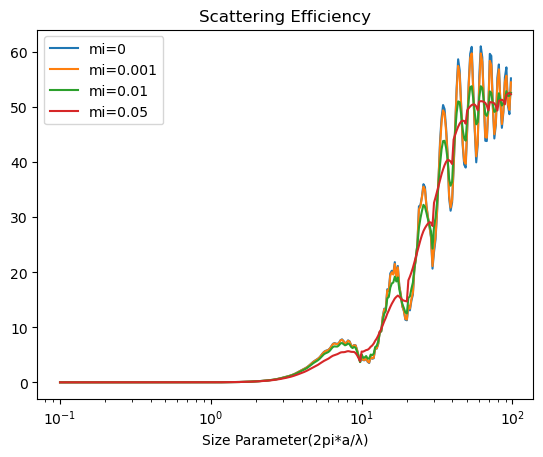

In [11]:
X = [10.**x for x in np.arange(-1,2,0.01)]
fig,ax  = plt.subplots()
print(X)
for mi in [0,0.001,0.01,0.05]:
    m = complex(1.34,-mi)
    qsca = [Qsca(x,m*x,m,iter=int((x//10+1)*10)) for x in X]


    ax.plot(X,qsca,label=f"mi={mi}")
ax.set_xscale("log");ax.legend()
ax.set_title("Scattering Efficiency")
ax.set_xlabel("Size Parameter(2pi*a/λ)")
#ax.set_ylim(0,15)
plt.show()